In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import discovery as ds
import json
import numpy as np
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)
import argparse
from functools import partial
import json
import discovery.samplers.numpyro as ds_numpyro
from pathlib import Path
import pickle
import corner
import inspect
import typing
import copy
import random

In [ ]:
feather_dir = "./data_products/"

## EDITED VERSION OF HESSIAN CHECK CODE

The discovery simulation code is not working. However, the likelihood recovery code is working. I need to adapt what I've done in discovery to work for enterprise instead, and then tie that directly into the discovery likelihood function

In [3]:
from enterprise.signals import signal_base

import numpy as np
import scipy.linalg as sl
import scipy.sparse as ss
from sksparse.cholmod import cholesky
from enterprise.signals import signal_base
from enterprise.signals.gp_signals import get_timing_model_basis, BasisGP
from enterprise.signals.parameter import function
from enterprise_extensions import load_feathers


def simulate(pta, params, sparse_cholesky=True):
    """Simulate code with enterprise (instead of libstempo/PINT)"""
    delays, ndiags, fmats, phis = (pta.get_delay(params=params),
                                   pta.get_ndiag(params=params),
                                   pta.get_basis(params=params),
                                   pta.get_phi(params=params))

    gpresiduals = []
    if pta._commonsignals:
        if sparse_cholesky:
            cf = cholesky(ss.csc_matrix(phis))
            gp = np.zeros(phis.shape[0])
            gp[cf.P()] = np.dot(cf.L().toarray(), np.random.randn(phis.shape[0]))
        else:
            gp = np.dot(sl.cholesky(phis, lower=True), np.random.randn(phis.shape[0]))

        i = 0
        for fmat in fmats:
            j = i + fmat.shape[1]
            gpresiduals.append(np.dot(fmat, gp[i:j]))
            i = j

        assert len(gp) == i
    else:
        for fmat, phi in zip(fmats, phis):
            if phi is None:
                gpresiduals.append(0)
            elif phi.ndim == 1:
                gpresiduals.append(np.dot(fmat, np.sqrt(phi) * np.random.randn(phi.shape[0])))
            else:
                raise NotImplementedError

    whiteresiduals = []
    for delay, ndiag in zip(delays, ndiags):
        if ndiag is None:
            whiteresiduals.append(0)
        elif isinstance(ndiag, signal_base.ShermanMorrison):
            # this code is very slow...
            n = np.diag(ndiag._nvec)
            for j,s in zip(ndiag._jvec, ndiag._slices):
                n[s,s] += j
            whiteresiduals.append(delay + np.dot(sl.cholesky(n, lower=True), np.random.randn(n.shape[0])))
        elif ndiag.ndim == 1:
            whiteresiduals.append(delay + np.sqrt(ndiag) * np.random.randn(ndiag.shape[0]))
        else:
            raise NotImplementedError

    return [np.array(g + w) for g, w in zip(gpresiduals, whiteresiduals)]

def set_residuals(psr, y):
    psr._residuals[psr._isort] = y

@function
def tm_prior(weights, toas, variance=1e40):
    return weights * variance * len(toas)

def TimingModel(coefficients=False, name="linear_timing_model",
                use_svd=False, normed=True, prior_variance=1e40):
    """Class factory for marginalized linear timing model signals."""

    basis = get_timing_model_basis(use_svd, normed)
    prior = tm_prior(variance=prior_variance)

    BaseClass = BasisGP(prior, basis, coefficients=coefficients, name=name)

    class TimingModel(BaseClass):
        signal_type = "basis"
        signal_name = "linear timing model"
        signal_id = name + "_svd" if use_svd else name

    return TimingModel


/home/mattm/miniforge3/envs/discotech/lib/python3.12/site-packages/enterprise/signals/utils.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import Requirement, resource_filename


In [4]:
psrs = load_feathers.load_feathers_from_folder(feather_dir)

FeatherPulsar.read_feather: cannot find dmx in feather file ./from_polina/B1855+09.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./from_polina/B1855+09.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./from_polina/B1937+21.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./from_polina/B1937+21.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./from_polina/B1953+29.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./from_polina/B1953+29.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./from_polina/J0023+0923.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./from_polina/J0023+0923.feather.
FeatherPulsar.read_feather: cannot find dmx in feather file ./from_polina/J0030+0451.feather.
FeatherPulsar.read_feather: cannot find _pdist in feather file ./from_polina/J0030+0451.feather.
FeatherPulsar.read_feather: cannot find dmx in feather fi

In [5]:
psrs

[<Pulsar B1855+09: 226 res, 15 pars>,
 <Pulsar B1937+21: 574 res, 8 pars>,
 <Pulsar B1953+29: 202 res, 14 pars>,
 <Pulsar J0023+0923: 155 res, 17 pars>,
 <Pulsar J0030+0451: 599 res, 8 pars>,
 <Pulsar J0125-2327: 188 res, 8 pars>,
 <Pulsar J0340+4130: 245 res, 8 pars>,
 <Pulsar J0406+3039: 198 res, 8 pars>,
 <Pulsar J0437-4715: 230 res, 8 pars>,
 <Pulsar J0509+0856: 198 res, 8 pars>,
 <Pulsar J0557+1551: 224 res, 8 pars>,
 <Pulsar J0605+3757: 193 res, 8 pars>,
 <Pulsar J0610-2100: 193 res, 8 pars>,
 <Pulsar J0613-0200: 391 res, 16 pars>,
 <Pulsar J0614-3329: 167 res, 8 pars>,
 <Pulsar J0636+5128: 184 res, 14 pars>,
 <Pulsar J0636-3044: 166 res, 8 pars>,
 <Pulsar J0645+5158: 214 res, 8 pars>,
 <Pulsar J0709+0458: 224 res, 8 pars>,
 <Pulsar J0711-6830: 575 res, 8 pars>,
 <Pulsar J0740+6620: 182 res, 15 pars>,
 <Pulsar J0751+1807: 367 res, 8 pars>,
 <Pulsar J0900-3144: 177 res, 8 pars>,
 <Pulsar J0931-1902: 229 res, 8 pars>,
 <Pulsar J0955-6150: 170 res, 8 pars>,
 <Pulsar J1012+5307: 359 

In [6]:
for psr in psrs:
    psr._pdist = psr.pdist

## Construct psr signal model (in enterprise)

In [17]:
from enterprise.signals import selections
import enterprise.signals.parameter as parameter
from enterprise.signals import white_signals
from enterprise_extensions.blocks import common_red_noise_block
from enterprise.signals import gp_signals    
from enterprise.signals import utils
from enterprise_extensions import deterministic

tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

selection = selections.Selection(selections.by_backend)
efac = parameter.Constant(1)
equad = parameter.Constant(-8)
# ecorr = parameter.Constant(-8)

log10_A_red = parameter.Uniform(-18, -11)
gamma_red = parameter.Uniform(0, 7)
log10_A_gw = parameter.Uniform(-18,-11)('log10_A_gw')
gamma_gw = parameter.Uniform(0,7)('gamma_gw')

components = 30

tm = TimingModel(coefficients=False, name="linear_timing_model",
                use_svd=False, normed=True, prior_variance=1e-14)
models = []
for p in psrs:
    s = tm

    ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
    s += ef

    eq = white_signals.TNEquadNoise(log10_tnequad=equad, selection=selection)
    s += eq

    # ec = gp_signals.EcorrBasisModel(log10_ecorr=ecorr,selection=selection)
    # s += ec

    pl = utils.powerlaw(log10_A=log10_A_red, gamma=gamma_red)
    rn = gp_signals.FourierBasisGP(spectrum=pl, components=components, Tspan=Tspan, name="rednoise")
    s += rn

    ## HD Correlated signal
    crn = common_red_noise_block(psd='powerlaw', prior='log-uniform',
                        components=components, orf='hd', name='gwb')

    #cw = deterministic.cw_delay_disco_clone()

    cw = deterministic.cw_block_circ(amp_prior="log-uniform", dist_prior=None, skyloc=None, 
                                     log10_fgw=None, psrTerm=True, discoclone=True, name="cw")

    s += crn
    s += cw 

    models.append(s(p))
    print(p.name)
pta = signal_base.PTA(models)

pta.set_default_params({})

B1855+09
B1937+21
B1953+29
J0023+0923
J0030+0451
J0125-2327
J0340+4130
J0406+3039
J0437-4715
J0509+0856
J0557+1551
J0605+3757
J0610-2100
J0613-0200
J0614-3329
J0636+5128
J0636-3044
J0645+5158
J0709+0458
J0711-6830
J0740+6620
J0751+1807
J0900-3144
J0931-1902
J0955-6150
J1012+5307
J1012-4235
J1017-7156
J1022+1001
J1024-0719
J1036-8317
J1045-4509
J1101-6424
J1103-5403
J1125+7819
J1125-5825
J1125-6014
J1216-6410
J1312+0051
J1327-0755
J1421-4409
J1431-5740
J1435-6100
J1446-4701
J1453+1902
J1455-3330
J1525-5545
J1543-5149
J1545-4550
J1547-5709
J1600-3053
J1603-7202
J1614-2230
J1629-6902
J1630+3734
J1640+2224
J1643-1224
J1652-4838
J1653-2054
J1658-5324
J1705-1903
J1708-3506
J1713+0747
J1719-1438
J1721-2457
J1730-2304
J1732-5049
J1737-0811
J1738+0333
J1741+1351
J1744-1134
J1745+1017
J1747-4036
J1751-2857
J1756-2251
J1757-5322
J1801-1417
J1802-2124
J1804-2717
J1811-2405
J1824-2452A
J1825-0319
J1832-0836
J1843-1113
J1853+1303
J1902-5105
J1903+0327
J1903-7051
J1909-3744
J1910+1256
J1911+1347
J191

In [18]:
print(pta.summary())

enterprise v3.4.4,  Python v3.12.11

Signal Name                              Signal Class                   no. Parameters      
B1855+09_linear_timing_model             TimingModel                    0                   

params:
__________________________________________________________________________________________
B1855+09_measurement_noise               MeasurementNoise               0                   

params:
B1855+09_KAT_MKBF_efac:Constant=1                                                         
__________________________________________________________________________________________
B1855+09_tnequad                         TNEquadNoise                   0                   

params:
B1855+09_KAT_MKBF_log10_tnequad:Constant=-8                                               
__________________________________________________________________________________________
B1855+09_rednoise                        FourierBasisGP                 2                   

Basis shape (Nt

In [19]:
enterprise_params ={}
enterprise_params.update({p: np.random.uniform(-18,-17) for p in pta.param_names if 'rednoise_log10_A' in p})
enterprise_params.update({p: np.random.uniform(1,7) for p in pta.param_names if 'rednoise_gamma' in p})

for psr in psrs:
    enterprise_params.update({p: psr.pdist[0] for p in pta.param_names if psr.name+'_cw_p_dist' in p})

enterprise_params.update({'gw_gamma': 4.333, 'gw_log10_A': -17.5})
enterprise_params.update({'cw_cosinc': 0, 'cw_log10_f0': -8, 'cw_log10_h0': -12, 'cw_phi_earth':np.pi, 'cw_psi': np.pi/4.0, 'cw_ra': 0.458, 'cw_sindec': 0.43})

In [20]:
pta._commonsignals

{}

In [21]:
res = simulate(pta, enterprise_params, sparse_cholesky=True)

In [22]:
res

[array([-1.47810188e-06, -4.65713456e-07,  4.06525678e-07,  1.94073633e-06,
         7.59307053e-07,  7.90998243e-07,  7.35407395e-07,  6.27565493e-07,
         1.17097076e-06,  1.69960078e-06,  2.56619581e-06,  3.41259908e-06,
         3.85727155e-06,  5.15484773e-06,  4.27711226e-06,  4.21933563e-06,
         5.07369402e-06,  3.56264122e-06,  2.68173673e-06,  1.65392205e-06,
         1.59032072e-06,  1.05732001e-07,  2.99469850e-07, -7.05321897e-07,
        -2.18528749e-06, -1.44707578e-06, -2.69772063e-06, -1.54116796e-06,
        -5.45361568e-07,  4.83220963e-06,  4.53497256e-06,  4.23296716e-06,
         4.24002623e-06,  3.41434013e-06,  8.11141360e-07,  9.15267195e-07,
         2.16825003e-07, -9.21288242e-08, -2.45091500e-06, -4.07393779e-06,
        -3.38706634e-06, -3.96573450e-06, -3.90345792e-06, -1.80050422e-06,
        -1.98717023e-06, -1.38377679e-06,  6.92422366e-07,  1.37095733e-06,
         1.02498838e-06,  3.07984900e-06,  3.30508980e-06,  5.48480110e-06,
         5.2

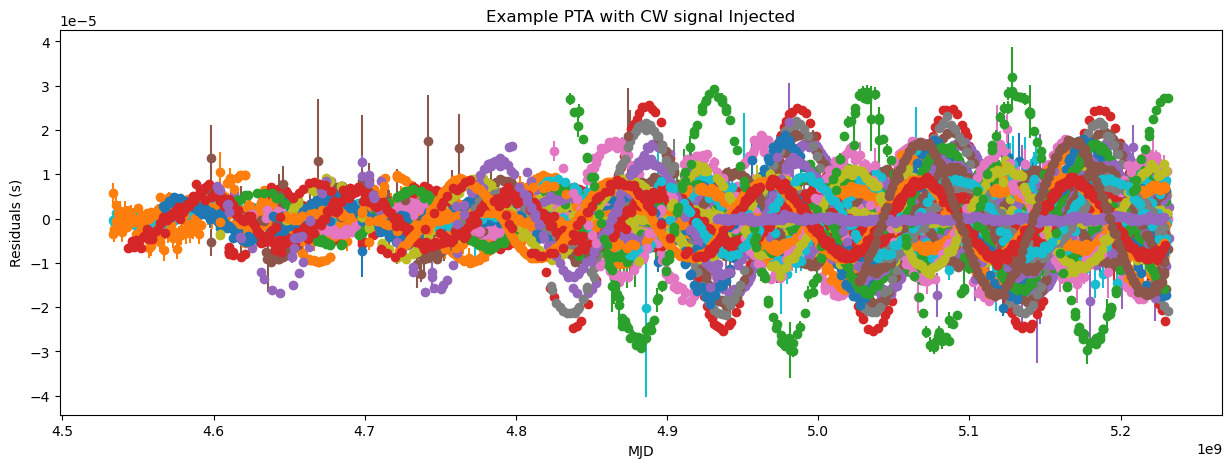

In [23]:
# Check numpy pulsars
plt.figure(figsize=(15,5))
for i, res_i in enumerate(res):
    plt.errorbar(psrs[i].toas, res_i, yerr=psrs[i].toaerrs, fmt='o')
    plt.xlabel('MJD')   
    plt.ylabel('Residuals (s)')
    plt.title("Example PTA with CW signal Injected")

In [24]:
disco_psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(feather_dir+'*.feather'))] #For now just grabbing 20 psrs

In [25]:
for i, dpsr in enumerate(disco_psrs):
    dpsr.residuals = np.array(res[i])

In [26]:
for dpsr in disco_psrs:
    wn_level = 1e-6
    dpsr.toaerrs = np.array(len(dpsr.toas) *[wn_level])

In [27]:
len(dpsr.residuals)

168

In [28]:
len(dpsr.toas)

168

In [29]:
len(dpsr.toaerrs)

168

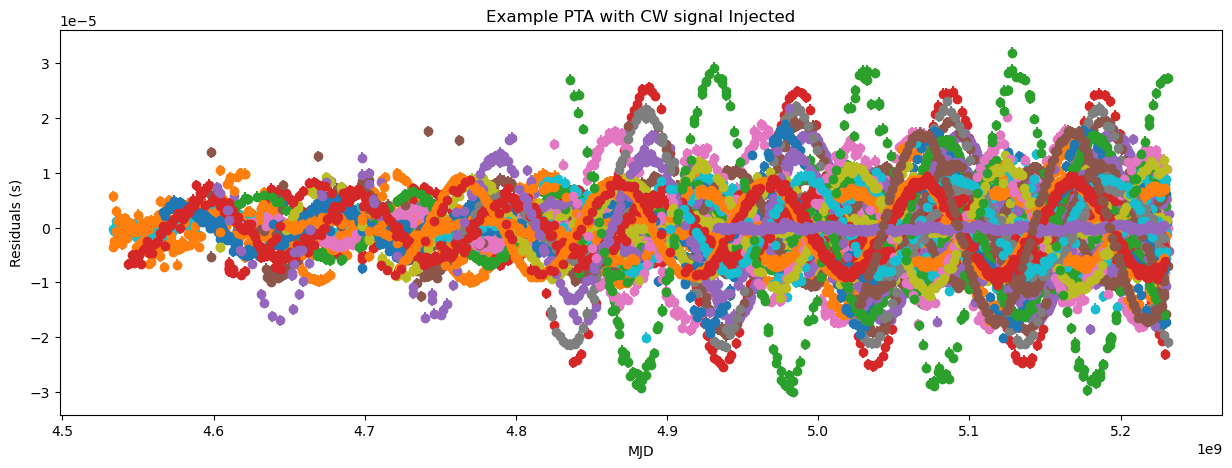

In [30]:
#Check jax pulsars

plt.figure(figsize=(15,5))
for i, dpsr in enumerate(disco_psrs):
    plt.errorbar(dpsr.toas, dpsr.residuals, yerr=dpsr.toaerrs, fmt='o')
    plt.xlabel('MJD')   
    plt.ylabel('Residuals (s)')
    plt.title("Example PTA with CW signal Injected")

### Set up signal model below:

In [31]:
# Custom function to use the p_dist rather than p_phase


def fpc_fast(pos, gwtheta, gwphi):
    x, y, z = pos

    sin_phi = jnp.sin(gwphi)
    cos_phi = jnp.cos(gwphi)
    sin_theta = jnp.sin(gwtheta)
    cos_theta = jnp.cos(gwtheta)

    m_dot_pos = sin_phi * x - cos_phi * y
    n_dot_pos = -cos_theta * cos_phi * x - cos_theta * sin_phi * y + sin_theta * z
    omhat_dot_pos = -sin_theta * cos_phi * x - sin_theta * sin_phi * y - cos_theta * z

    denom = 1.0 + omhat_dot_pos

    fplus = 0.5 * (m_dot_pos**2 - n_dot_pos**2) / denom
    fcross = (m_dot_pos * n_dot_pos) / denom

    return fplus, fcross
    
def cos2comp(f, df, A, f0, phi, t0):
    """Project signal A * cos(2pi f t + phi) onto Fourier basis
    cos(2pi k t/T), sin(2pi k t/T) for t in [t0, t0+T]."""

    T = 1.0 / df[0]

    Delta_omega = 2.0 * jnp.pi * (f0 - f[::2])
    Sigma_omega = 2.0 * jnp.pi * (f0 + f[::2])

    phase_Delta_start = phi + Delta_omega * t0
    phase_Delta_end   = phi + Delta_omega * (t0 + T)

    phase_Sigma_start = phi + Sigma_omega * t0
    phase_Sigma_end   = phi + Sigma_omega * (t0 + T)

    ck = (A / T) * (
        (jnp.sin(phase_Delta_end) - jnp.sin(phase_Delta_start)) / Delta_omega +
        (jnp.sin(phase_Sigma_end) - jnp.sin(phase_Sigma_start)) / Sigma_omega
    )

    sk = (A / T) * (
        (jnp.cos(phase_Delta_end) - jnp.cos(phase_Delta_start)) / Delta_omega -
        (jnp.cos(phase_Sigma_end) - jnp.cos(phase_Sigma_start)) / Sigma_omega
    )

    return jnp.stack((sk, ck), axis=1).reshape(-1)



def makefourier_binary_pdist(pulsarterm=True):
    def fourier_binary_pdist(f, df, mintoa, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, p_dist):
        h0 = 10**log10_h0
        f0 = 10**log10_f0

        pos = jnp.array(pos)
        
        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

        # calculate antenna pattern
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)

        c = 2.99792458e8 
        omega_hat = jnp.array([ -jnp.cos(dec) * jnp.cos(ra), 
                                -jnp.cos(dec) * jnp.sin(ra),
                                -jnp.sin(dec)
                              ])

        # Convert pulsar distance from kpc to meters to match c [m/s]
        p_dist_m = p_dist * 3.0856775814913673e19  # 1 kpc in meters
        phi_psr = (p_dist_m / c) * 2.0 * jnp.pi * f0  * (1.0 + jnp.dot(omega_hat, pos))

        if pulsarterm:
            phi_avg = 0.5 * (phi_earth + phi_psr)
        else:
            phi_avg = phi_earth

        tref = 86400.0 * 51544.5  # MJD J2000 in seconds

        cphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref, mintoa)
        sphase = cos2comp(f, df, 1.0, f0, phi_avg - 2.0 * jnp.pi * f0 * tref - 0.5 * jnp.pi, mintoa)

        if pulsarterm:
            phi_diff = 0.5 * (phi_earth - phi_psr)
            sin_diff = jnp.sin(phi_diff)

            delta_sin =  2.0 * cphase * sin_diff
            delta_cos = -2.0 * sphase * sin_diff
        else:
            delta_sin = sphase
            delta_cos = cphase

        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt =  2.0 * jnp.cos(inc) * delta_cos

        alpha = h0 / (2 * jnp.pi * f0)

        rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

        res = -fplus * rplus - fcross * rcross

        return res

    if not pulsarterm:
        fourier_binary_pdist = functools.partial(fourier_binary, p_dist=jnp.nan)

    return fourier_binary_pdist

In [32]:
disco_psrs = disco_psrs[:10]

In [33]:
# Injected with effectively no WN

noisedict = {}
for dpsr in disco_psrs:
    noisedict[dpsr.name+"_KAT_MKBF_efac"] = 1 # EFAC=1 means no EFAC
    noisedict[dpsr.name+"_KAT_MKBF_log10_ecorr"] = -8 # Bringing these down to effectively 0
    noisedict[dpsr.name+"_KAT_MKBF_log10_t2equad"] = -8

In [34]:
# Fourier based CW delay
fourdelay = makefourier_binary_pdist(pulsarterm=True)
cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']

T = ds.getspan(disco_psrs)
fml = ds.ArrayLikelihood([ds.PulsarLikelihood([dpsr.residuals,
                                               ds.makenoise_measurement(dpsr, noisedict=noisedict),
                                               ds.makegp_timing(dpsr, variance=1e-14),
                                               #ds.makegp_fourier(dpsr, ds.powerlaw, 30, T=ds.getspan(dpsr), name='rednoise')
                                               ]) for dpsr in disco_psrs],
                        #globalgp = ds.makegp_fourier_global(psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T=T, means = fourdelay, common = ['crn_gamma', 'crn_log10_A'] +cwcommon, name='crn', meansname='cw'))
                        #globalgp = ds.makecommongp_fourier(psrs, ds.powerlaw, 30, T, means=fourdelay, common=['crn_gamma', 'crn_log10_A'] + cwcommon, name='rednoise', meansname='cw'))
                          commongp = ds.makecommongp_fourier(disco_psrs, ds.powerlaw, 30, T, name='rednoise'),
                          globalgp = ds.makeglobalgp_fourier(disco_psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T, means=fourdelay, common=cwcommon, name='gw', meansname='cw'))

In [35]:
# # Fourier based CW delay
# fourdelay = makefourier_binary_pdist(pulsarterm=True)
# cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']

# T = ds.getspan(psrs)
# fml = ds.GlobalLikelihood([ds.PulsarLikelihood([psr.residuals,
#                                                ds.makenoise_measurement(psr, noisedict=noisedict),
#                                                ds.makegp_timing(psr, variance=1e-14),
#                                                ds.makegp_fourier(psr, ds.powerlaw, 30, T=ds.getspan(psr), name='rednoise')
#                                                ]) for psr in psrs],
#                         globalgp = ds.makegp_fourier_global(psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T=T, common = ['crn_gamma', 'crn_log10_A'], name='crn'))

In [36]:
dpsr.residuals

array([ 8.58738395e-07,  4.55465571e-08,  2.30348311e-06,  1.40211185e-06,
        1.84722065e-06,  2.28056480e-06,  3.34960587e-06,  2.72221748e-06,
        2.58475216e-06,  2.42013037e-06,  3.90986809e-06,  4.05239809e-06,
        4.62091580e-06,  4.54792194e-06,  4.12521623e-06,  4.50672527e-06,
        4.40968821e-06,  5.02553633e-06,  5.34978826e-06,  4.20779079e-06,
        6.50175627e-06,  6.68095600e-06,  4.79064421e-06,  5.07262296e-06,
        6.78638082e-06,  5.57363599e-06,  5.68401728e-06,  5.30217787e-06,
        3.82929556e-06,  4.64965766e-06,  5.40564623e-06,  3.49188522e-06,
        3.12771626e-06,  2.70504255e-06,  2.22759405e-06,  1.71408365e-06,
        1.32226353e-06,  1.66210662e-06,  2.03635864e-07,  1.28556904e-06,
        1.07006755e-07, -1.32009887e-07, -1.24113001e-06, -1.79230603e-06,
       -8.04486503e-07, -1.33491593e-06, -1.64130084e-06, -2.50361930e-06,
       -2.23626740e-06, -2.24074571e-06, -2.66715904e-06, -3.24872285e-06,
       -3.44748336e-06, -

In [37]:
ds.prior.priordict_standard.update({
    '(.*_)?cw_p_dist':     [0.1, 5]
})

In [38]:
for dpsr in disco_psrs:
    print(dpsr.pdist)

[1.18, 0.12]
[3.1, 0.2]
[4.64, 0.93]
[1.02, 0.11]
[0.3296, 0.0036]
[0.873, 0.1746]
[1.71, 0.34]
[1.72, 0.34]
[0.1549, 0.001]
[1.45, 0.29]


In [39]:
fml.logL.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_log10_f0',
 'cw_log10_h0',
 'cw_phi_earth',
 'cw_psi',
 'cw_ra',
 'cw_sindec',
 'gw_gamma',
 'gw_log10_A']

In [40]:
temp_freeze = [ key for key in fml.logL.params if  'cw_p_dist' in key ]

In [41]:
temp_freeze

['B1855+09_cw_p_dist',
 'B1937+21_cw_p_dist',
 'B1953+29_cw_p_dist',
 'J0023+0923_cw_p_dist',
 'J0030+0451_cw_p_dist',
 'J0125-2327_cw_p_dist',
 'J0340+4130_cw_p_dist',
 'J0406+3039_cw_p_dist',
 'J0437-4715_cw_p_dist',
 'J0509+0856_cw_p_dist']

In [42]:
# Quick check that finding the parameters is possible

# Freeze selected global CW/GW parameters at their injected values for NumPyro
_base_logl = fml.logL
# _fixed_names = [
#     'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth',
#     'cw_psi', 'cw_ra', 'cw_sindec', 'gw_gamma', 'gw_log10_A'
# ]
_fixed_names = temp_freeze

_fixed_dict = {k: float(enterprise_params[k]) for k in _fixed_names
               if k in _base_logl.params and k in enterprise_params}

def logl(pfree):
    params = dict(_fixed_dict)
    params.update(pfree)
    return _base_logl(params)

# Expose only free parameters to the sampler
logl.params = tuple(k for k in _base_logl.params if k not in _fixed_dict)

# Uniform priors and a random draw for a quick smoke test
logp = ds.makelogprior_uniform(logl.params)
p0 = ds.sample_uniform(logl.params)

# Quick checks
logl(p0)
jax.jit(logl)(p0)
jax.grad(logl)(p0)


{'B1855+09_rednoise_gamma': Array(0.48040593, dtype=float64, weak_type=True),
 'B1855+09_rednoise_log10_A': Array(-81.53665879, dtype=float64, weak_type=True),
 'B1937+21_rednoise_gamma': Array(-2.91542506, dtype=float64, weak_type=True),
 'B1937+21_rednoise_log10_A': Array(-100.86027606, dtype=float64, weak_type=True),
 'B1953+29_rednoise_gamma': Array(-0.41047543, dtype=float64, weak_type=True),
 'B1953+29_rednoise_log10_A': Array(0.31818918, dtype=float64, weak_type=True),
 'J0023+0923_rednoise_gamma': Array(-0.38256608, dtype=float64, weak_type=True),
 'J0023+0923_rednoise_log10_A': Array(-65.03162763, dtype=float64, weak_type=True),
 'J0030+0451_rednoise_gamma': Array(1.91356336e-12, dtype=float64, weak_type=True),
 'J0030+0451_rednoise_log10_A': Array(8.26562674e-11, dtype=float64, weak_type=True),
 'J0125-2327_rednoise_gamma': Array(4.03225138e-06, dtype=float64, weak_type=True),
 'J0125-2327_rednoise_log10_A': Array(-0.00016295, dtype=float64, weak_type=True),
 'J0340+4130_redn

In [43]:
logl = fml.logL

In [44]:
logl.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_log10_f0',
 'cw_log10_h0',
 'cw_phi_earth',
 'cw_psi',
 'cw_ra',
 'cw_sindec',
 'gw_gamma',
 'gw_log10_A']

In [45]:
temp_dict = enterprise_params.copy()


In [46]:
logl(temp_dict)

Array(37017.58478914, dtype=float64)

In [47]:
temp_dict

{'B1855+09_rednoise_log10_A': -17.733691903159446,
 'B1937+21_rednoise_log10_A': -17.085479733862073,
 'B1953+29_rednoise_log10_A': -17.28362719879896,
 'J0023+0923_rednoise_log10_A': -17.829696358051642,
 'J0030+0451_rednoise_log10_A': -17.33091391562451,
 'J0125-2327_rednoise_log10_A': -17.33534863438109,
 'J0340+4130_rednoise_log10_A': -17.806447069196842,
 'J0406+3039_rednoise_log10_A': -17.564694734141206,
 'J0437-4715_rednoise_log10_A': -17.632921679634684,
 'J0509+0856_rednoise_log10_A': -17.324136865949463,
 'J0557+1551_rednoise_log10_A': -17.500116903389642,
 'J0605+3757_rednoise_log10_A': -17.43401064422031,
 'J0610-2100_rednoise_log10_A': -17.46972429678885,
 'J0613-0200_rednoise_log10_A': -17.189853651840338,
 'J0614-3329_rednoise_log10_A': -17.388477280565528,
 'J0636+5128_rednoise_log10_A': -17.086697998219808,
 'J0636-3044_rednoise_log10_A': -17.6100529973009,
 'J0645+5158_rednoise_log10_A': -17.55528119748524,
 'J0709+0458_rednoise_log10_A': -17.467651705983002,
 'J0711

In [48]:
trial_x0 = ds.sample_uniform(logl.params)

In [49]:
type(trial_x0)

dict

In [50]:
logl(trial_x0)

Array(1276.60601678, dtype=float64)

In [51]:
jax.jit(logl)(trial_x0)

Array(1276.60601678, dtype=float64)

In [52]:
logl(temp_dict)

Array(37017.58478914, dtype=float64)

In [53]:
jax.jit(logl)(temp_dict)

Array(-72784.78640835, dtype=float64)

In [54]:
#Need to sort dict so it remains in the same order as the logl.params
order_map = {key: i for i, key in enumerate(logl.params)}

sorted_items = sorted(temp_dict.items(), key=lambda item: order_map.get(item[0], float('inf')))
sorted_dict = dict(sorted_items)

In [55]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 1.3096923382573649,
 'B1855+09_rednoise_log10_A': -17.733691903159446,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 2.847327717482939,
 'B1937+21_rednoise_log10_A': -17.085479733862073,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 2.2164048556533174,
 'B1953+29_rednoise_log10_A': -17.28362719879896,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 3.2001193207841823,
 'J0023+0923_rednoise_log10_A': -17.829696358051642,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 5.778289545737763,
 'J0030+0451_rednoise_log10_A': -17.33091391562451,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 5.449700355175006,
 'J0125-2327_rednoise_log10_A': -17.33534863438109,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 3.681041620829264,
 'J0340+4130_rednoise_log10_A': -17.806447069196842,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 4.773565477728963,
 'J04

In [56]:
logl.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_log10_f0',
 'cw_log10_h0',
 'cw_phi_earth',
 'cw_psi',
 'cw_ra',
 'cw_sindec',
 'gw_gamma',
 'gw_log10_A']

In [57]:
logl(sorted_dict)

Array(37017.58478914, dtype=float64)

In [58]:
jax.jit(logl)(sorted_dict)

Array(-72784.78640835, dtype=float64)

In [59]:
param_keys = list(sorted_dict.keys())

# Define the wrapper
def logl_wrapped(x_array):
    # Convert array -> dict
    params = {k: v for k, v in zip(param_keys, x_array)}
    return logl(params)

In [60]:
logl_fn = jax.jit(logl_wrapped)

In [61]:
x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
logl_fn(x0)

Array(37017.58478915, dtype=float64)

In [62]:
%timeit
x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)

In [63]:
logl.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'cw_cosinc',
 'cw_log10_f0',
 'cw_log10_h0',
 'cw_phi_earth',
 'cw_psi',
 'cw_ra',
 'cw_sindec',
 'gw_gamma',
 'gw_log10_A']

In [64]:
enterprise_params

{'B1855+09_rednoise_log10_A': -17.733691903159446,
 'B1937+21_rednoise_log10_A': -17.085479733862073,
 'B1953+29_rednoise_log10_A': -17.28362719879896,
 'J0023+0923_rednoise_log10_A': -17.829696358051642,
 'J0030+0451_rednoise_log10_A': -17.33091391562451,
 'J0125-2327_rednoise_log10_A': -17.33534863438109,
 'J0340+4130_rednoise_log10_A': -17.806447069196842,
 'J0406+3039_rednoise_log10_A': -17.564694734141206,
 'J0437-4715_rednoise_log10_A': -17.632921679634684,
 'J0509+0856_rednoise_log10_A': -17.324136865949463,
 'J0557+1551_rednoise_log10_A': -17.500116903389642,
 'J0605+3757_rednoise_log10_A': -17.43401064422031,
 'J0610-2100_rednoise_log10_A': -17.46972429678885,
 'J0613-0200_rednoise_log10_A': -17.189853651840338,
 'J0614-3329_rednoise_log10_A': -17.388477280565528,
 'J0636+5128_rednoise_log10_A': -17.086697998219808,
 'J0636-3044_rednoise_log10_A': -17.6100529973009,
 'J0645+5158_rednoise_log10_A': -17.55528119748524,
 'J0709+0458_rednoise_log10_A': -17.467651705983002,
 'J0711

In [65]:
# from tqdm import tqdm

# distance1 = np.linspace(0.01, 5, 50)
# distance2 = np.linspace(0.01, 5, 50)
# distance3 = np.linspace(0.01, 5, 50)
# logls = []
# temp_dict = enterprise_params.copy()

# order_map = {key: i for i, key in enumerate(logl.params)}

# sorted_items = sorted(temp_dict.items(), key=lambda item: order_map.get(item[0], float('inf')))
# sorted_dict = dict(sorted_items)

# for d1 in tqdm(distance1, desc="Distance 1 Loop"):
#     sorted_dict['J0437-4715_cw_p_dist'] = d1
#     for d2 in distance2:
#         sorted_dict['J0030+0451_cw_p_dist'] = d2
#         for d3 in distance3:
#             sorted_dict['J0125-2327_cw_p_dist'] = d3
#             x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
#             logls.append(logl_fn(x0))
#             #logls.append(logl(temp_dict))

    

In [98]:
print(enterprise_params['J0437-4715_cw_p_dist'])
print(enterprise_params['J0030+0451_cw_p_dist'])
print(enterprise_params['J0125-2327_cw_p_dist'])

0.1549
0.3296
0.873


In [99]:
from tqdm import tqdm

# Distance grids
distance1 = jnp.linspace(0.01, 0.2, 100)
distance2 = jnp.linspace(0.25, 0.4, 100)
distance3 = jnp.linspace(0.8, 1, 100)

# Precompute everything that’s constant
order_map = {key: i for i, key in enumerate(logl.params)}
sorted_items = sorted(enterprise_params.items(), key=lambda item: order_map.get(item[0], float('inf')))
base_params = jnp.array(list(dict(sorted_items).values()), dtype=jnp.float64)

# Get indices of the 3 pulsar-distance parameters in the array
i1 = order_map['J0437-4715_cw_p_dist']
i2 = order_map['J0030+0451_cw_p_dist']
i3 = order_map['J0125-2327_cw_p_dist']

# Make a full 3D meshgrid of parameter values
D1, D2, D3 = jnp.meshgrid(distance1, distance2, distance3, indexing='ij')
npts = D1.size

# Flatten for vectorized evaluation
D1f, D2f, D3f = D1.ravel(), D2.ravel(), D3.ravel()

def make_params(d1, d2, d3):
    """Return parameter vector with given distances."""
    vec = base_params.at[i1].set(d1)
    vec = vec.at[i2].set(d2)
    vec = vec.at[i3].set(d3)
    return vec

# Vectorize logl_fn over all (d1, d2, d3)
@jax.jit
@jax.vmap
def eval_logl(d1, d2, d3):
    return logl_fn(make_params(d1, d2, d3))

logls = []

for i in tqdm(range(0, npts, 4096)):
    sl = slice(i, i + 4096)
    logls_chunk = eval_logl(D1f[sl], D2f[sl], D3f[sl])
    logls.append(logls_chunk)

logls = jnp.concatenate(logls)


  0%|          | 0/245 [00:00<?, ?it/s]

100%|██████████| 245/245 [00:41<00:00,  5.95it/s]


In [89]:
logls.shape

(1000000,)

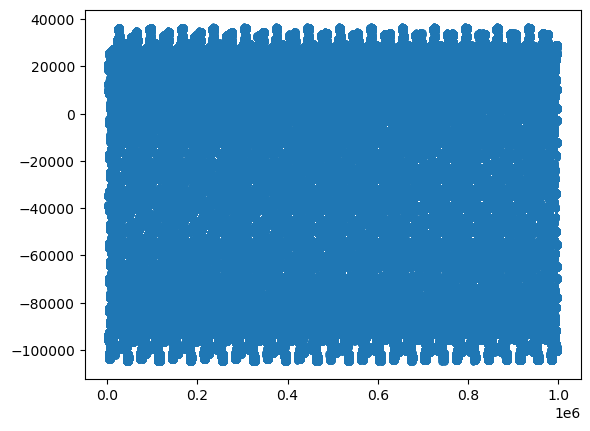

In [100]:
plt.plot(logls, ls="", marker=".")

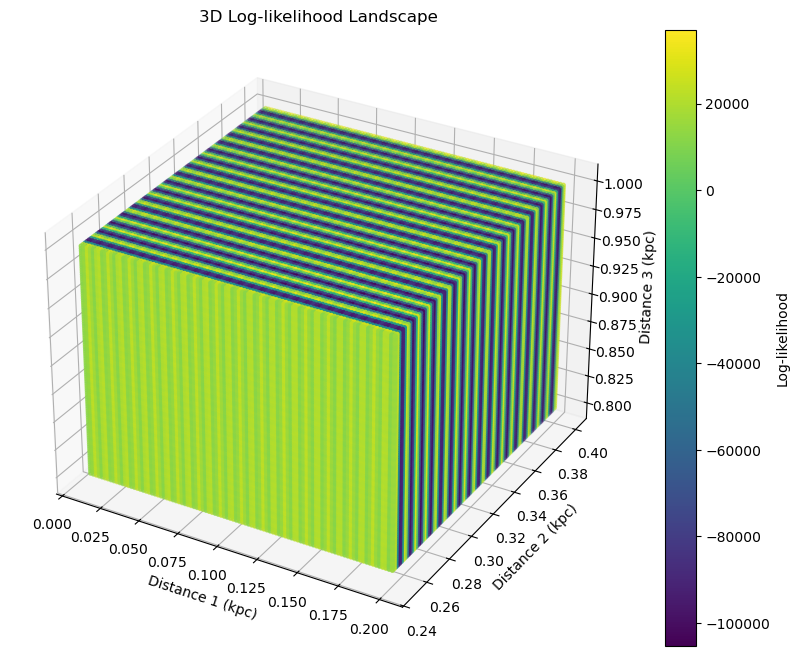

In [101]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Flatten everything
D1f = D1.ravel()
D2f = D2.ravel()
D3f = D3.ravel()
LNLf = logls.ravel()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(D1f, D2f, D3f, c=LNLf, cmap='viridis', s=8)
fig.colorbar(p, ax=ax, label='Log-likelihood')

ax.set_xlabel("Distance 1 (kpc)")
ax.set_ylabel("Distance 2 (kpc)")
ax.set_zlabel("Distance 3 (kpc)")
ax.set_title("3D Log-likelihood Landscape")

plt.show()

In [94]:
enterprise_params['J0125-2327_cw_p_dist']

0.873

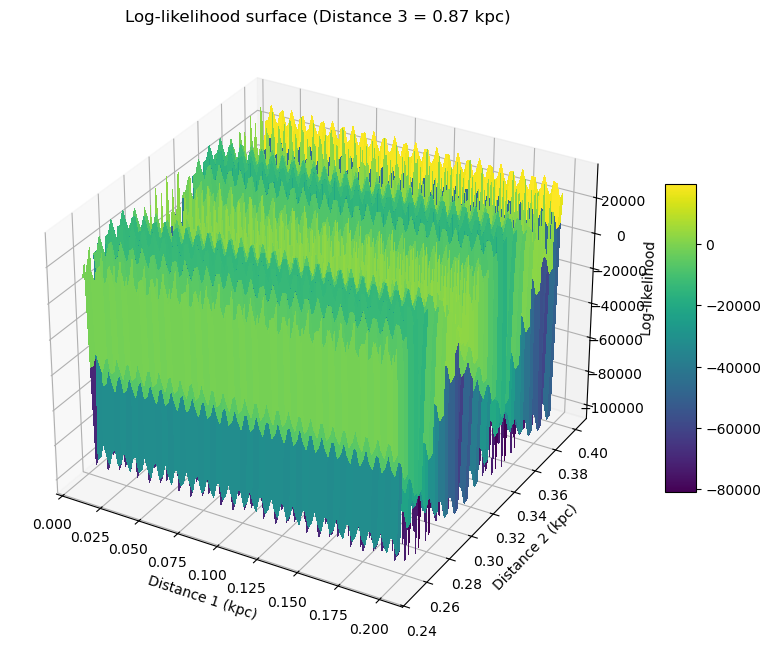

In [102]:


idx = jnp.searchsorted(distance3, enterprise_params['J0125-2327_cw_p_dist'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use meshgrid for the 2D plane
D1, D2 = jnp.meshgrid(distance1, distance2, indexing='ij')

# Plot the surface
surf = ax.plot_surface(D1, D2, logls.reshape(len(distance1), len(distance2), len(distance3))[:, :, idx],
                       cmap='viridis', linewidth=0, antialiased=False)

ax.set_xlabel("Distance 1 (kpc)")
ax.set_ylabel("Distance 2 (kpc)")
ax.set_zlabel("Log-likelihood")
ax.set_title(f"Log-likelihood surface (Distance 3 = {distance3[idx]:.2f} kpc)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()


In [104]:
! mamba install plotly -c conda-forge --yes

/home/mattm/miniforge3/envs/discotech/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0s
conda-forge/noarch   ━━━━━━━━━━━━━╸━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0s[+] 0.2s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━   1.8kB /  48.0MB @  12.2kB/s  0.1s
conda-forge/noarch   ━━━━━━━━━━━━━━╸━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s[+] 0.3s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━   1.7MB /  48.0MB @   6.7MB/s  0.2s
conda-forge/noarch   ━━━━━━━━━━━━━━━━━━━━━━━ 749.2kB /  22.9MB @   3.0MB/s  0.2s[+] 0.4s
conda-forge/linux-64 ━━╸━━━━━━━━━━━━━━━━━━━━   6.8MB /  48.0MB @  18.9MB/s  0.3s
conda-forge/noarch   ━╸━━━━━━━━━━━━━━━━━━━━━   2.8MB /  22.9MB @   7.8MB/s  0.3s[+] 0.5s
conda-forge/linux-64 ━━━━━╸━━━━━━━━━━━━━━━━━  13.0MB /  48.0MB @  27.7MB/s  0.4s
conda-forge/noarch   ━━━━━━━╸━━━━━━━━━━━━━━━   8.7MB /  22.9MB @  18.4MB/s  0.4s[+] 0.6s
conda-forge/linux-64 ━━━━━━━━╸━━━━━━━━━━━━━━  20.5MB /  48.0MB @  35.9MB/s  0.5s
conda-forge/noarch   ━━━━━━━━━━━━━━━╸━━━━━━━  16.2M

Text(0, 0.5, 'Distance 2 variation (kpc)')

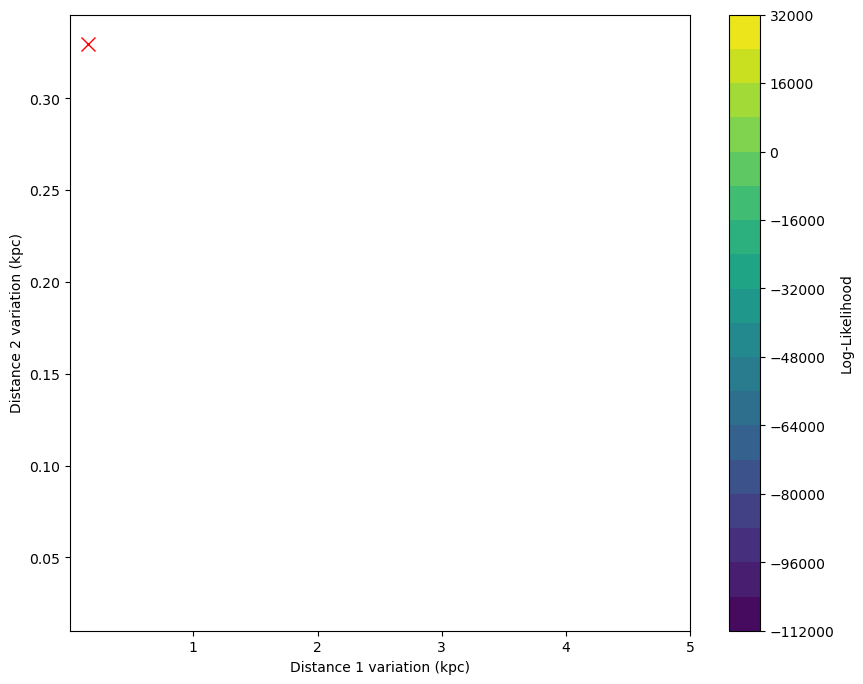

In [78]:
plt.figure(figsize=(10, 8))
plt.contourf(d1_grid[0], d2_grid[0], lnl_reshape[0], levels=20, cmap='viridis')
plt.plot(enterprise_params['J0437-4715_cw_p_dist'], enterprise_params['J0030+0451_cw_p_dist'], marker='x', color='red', markersize=10, label='Injected Value')
plt.colorbar(label='Log-Likelihood')
plt.xlabel("Distance 1 variation (kpc)")
plt.ylabel("Distance 2 variation (kpc)")

In [198]:
np.array(logls)

array([-31734.76933446, -81887.05222017,  31089.73331197, ...,
       -29154.69419708, -92470.62120349,  20369.74115201], shape=(10000,))

ValueError: x and y must have the same length.

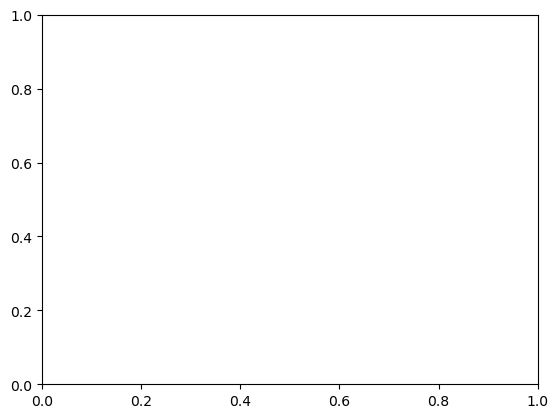

In [183]:
plt.hist2d(distance, logls, bins=30, cmap='Blues')

ValueError: x and y must be the same size

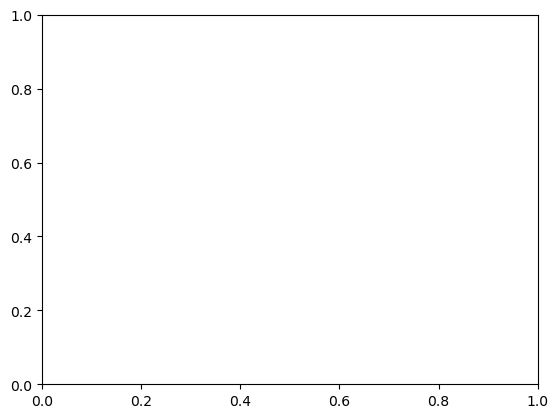

In [182]:
plt.scatter(distance, logls)
plt.axvline(enterprise_params['J0437-4715_cw_p_dist'], color='r', linestyle='--')


In [ ]:
enterprise_params['J0437-4715_cw_p_dist']

In [30]:
# Grab the injected values as a truth check
truths = {}
truths.update({p: enterprise_params[p] for p in fml.logL.params })

In [31]:
truths

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 5.414419042991917,
 'B1855+09_rednoise_log10_A': -17.284978290052635,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 2.0734167727284634,
 'B1937+21_rednoise_log10_A': -17.101623427225235,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 4.672016538095157,
 'B1953+29_rednoise_log10_A': -17.59211441605179,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 1.8193095046260999,
 'J0023+0923_rednoise_log10_A': -17.92149290839706,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 1.531484024557657,
 'J0030+0451_rednoise_log10_A': -17.090719035548737,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 5.6163925044425245,
 'J0125-2327_rednoise_log10_A': -17.856806919778606,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 2.2465439762004404,
 'J0340+4130_rednoise_log10_A': -17.58707276122303,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 5.795111452548936,
 'J0

In [32]:
order_map = {key: i for i, key in enumerate(fml.logL.params)}

In [33]:
order_map

{'B1855+09_cw_p_dist': 0,
 'B1855+09_rednoise_gamma': 1,
 'B1855+09_rednoise_log10_A': 2,
 'B1937+21_cw_p_dist': 3,
 'B1937+21_rednoise_gamma': 4,
 'B1937+21_rednoise_log10_A': 5,
 'B1953+29_cw_p_dist': 6,
 'B1953+29_rednoise_gamma': 7,
 'B1953+29_rednoise_log10_A': 8,
 'J0023+0923_cw_p_dist': 9,
 'J0023+0923_rednoise_gamma': 10,
 'J0023+0923_rednoise_log10_A': 11,
 'J0030+0451_cw_p_dist': 12,
 'J0030+0451_rednoise_gamma': 13,
 'J0030+0451_rednoise_log10_A': 14,
 'J0125-2327_cw_p_dist': 15,
 'J0125-2327_rednoise_gamma': 16,
 'J0125-2327_rednoise_log10_A': 17,
 'J0340+4130_cw_p_dist': 18,
 'J0340+4130_rednoise_gamma': 19,
 'J0340+4130_rednoise_log10_A': 20,
 'J0406+3039_cw_p_dist': 21,
 'J0406+3039_rednoise_gamma': 22,
 'J0406+3039_rednoise_log10_A': 23,
 'J0437-4715_cw_p_dist': 24,
 'J0437-4715_rednoise_gamma': 25,
 'J0437-4715_rednoise_log10_A': 26,
 'J0509+0856_cw_p_dist': 27,
 'J0509+0856_rednoise_gamma': 28,
 'J0509+0856_rednoise_log10_A': 29,
 'cw_cosinc': 30,
 'cw_log10_f0': 31,


In [ ]:
sorted_items = sorted(truths.items(), key=lambda item: order_map.get(item[0], float('inf')))
sorted_dict = dict(sorted_items)

In [36]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 5.414419042991917,
 'B1855+09_rednoise_log10_A': -17.284978290052635,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 2.0734167727284634,
 'B1937+21_rednoise_log10_A': -17.101623427225235,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 4.672016538095157,
 'B1953+29_rednoise_log10_A': -17.59211441605179,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 1.8193095046260999,
 'J0023+0923_rednoise_log10_A': -17.92149290839706,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 1.531484024557657,
 'J0030+0451_rednoise_log10_A': -17.090719035548737,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 5.6163925044425245,
 'J0125-2327_rednoise_log10_A': -17.856806919778606,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 2.2465439762004404,
 'J0340+4130_rednoise_log10_A': -17.58707276122303,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 5.795111452548936,
 'J0

In [37]:
sorted_dict.values()

dict_values([1.18, 5.414419042991917, -17.284978290052635, 3.1, 2.0734167727284634, -17.101623427225235, 4.64, 4.672016538095157, -17.59211441605179, 1.02, 1.8193095046260999, -17.92149290839706, 0.3296, 1.531484024557657, -17.090719035548737, 0.873, 5.6163925044425245, -17.856806919778606, 1.71, 2.2465439762004404, -17.58707276122303, 1.72, 5.795111452548936, -17.154157412601688, 0.1549, 2.193063121214756, -17.146174945586424, 1.45, 5.967315909463564, -17.49062113226821, 0, -8, -12, 3.141592653589793, 0.7853981633974483, 0.458, 0.43, 4.333, -17.5])

In [38]:
# logl = fml.cglogL(cgmaxiter=200, make_logdet='CG-MDL', detmatvecs=8, detsamples=256, clip=None)
# print("Using CG-based log-likelihood (ArrayLikelihood.cglogL)")

logl = fml.logL

In [39]:
# Get the keys in the same order as values
param_keys = list(sorted_dict.keys())

# Define the wrapper
def logl_wrapped(x_array):
    # Convert array -> dict
    params = {k: v for k, v in zip(param_keys, x_array)}
    return logl(params)

In [40]:
#x0 = np.array(list(sorted_dict.values()), dtype=np.float64)
x0 = jnp.array(list(sorted_dict.values()), dtype=jnp.float64)
logl_fn = jax.jit(logl_wrapped)
grad_fn = jax.jit(jax.grad(logl_fn))
hess_fn = jax.jit(jax.hessian(logl_fn))

# logl_fn = logl_wrapped
# grad_fn = jax.grad(logl_fn)
# hess_fn = jax.hessian(logl_fn)

In [41]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 5.414419042991917,
 'B1855+09_rednoise_log10_A': -17.284978290052635,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 2.0734167727284634,
 'B1937+21_rednoise_log10_A': -17.101623427225235,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 4.672016538095157,
 'B1953+29_rednoise_log10_A': -17.59211441605179,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 1.8193095046260999,
 'J0023+0923_rednoise_log10_A': -17.92149290839706,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 1.531484024557657,
 'J0030+0451_rednoise_log10_A': -17.090719035548737,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 5.6163925044425245,
 'J0125-2327_rednoise_log10_A': -17.856806919778606,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 2.2465439762004404,
 'J0340+4130_rednoise_log10_A': -17.58707276122303,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 5.795111452548936,
 'J0

In [114]:
print("logl(x0) =", logl_wrapped(x0))

logl(x0) = 36815.76494510537


In [115]:
x0.shape

(39,)

In [116]:
fml

In [117]:
G = grad_fn(x0)

In [118]:
G.shape

(39,)

In [119]:
H = hess_fn(x0)

In [126]:
np.linalg.cond(H)

np.float64(2.2166441563330937e+20)

In [94]:
H.shape

(357, 357)

In [121]:
H

Array([[-6.94574683e+10,  3.14845183e-02,  2.76319429e-02, ...,
         1.96713531e+10,  8.05106637e+01,  1.24546427e+02],
       [ 3.14845183e-02,  2.72733527e-05,  4.63770819e-05, ...,
        -8.92286082e-03, -9.78903886e-09, -1.51198630e-08],
       [ 2.76319429e-02,  4.63770819e-05,  8.56098580e-05, ...,
        -7.83571801e-03, -1.53681534e-08, -2.37579517e-08],
       ...,
       [ 1.96713531e+10, -8.92286082e-03, -7.83571801e-03, ...,
        -2.26179876e+12,  2.81327131e+02,  4.32702989e+02],
       [ 8.05106637e+01, -9.78903886e-09, -1.53681534e-08, ...,
         2.81327131e+02,  1.39364372e-01,  2.15372939e-01],
       [ 1.24546427e+02, -1.51198630e-08, -2.37579517e-08, ...,
         4.32702989e+02,  2.15372939e-01,  3.33419165e-01]],      dtype=float64)

In [96]:
sorted_dict

{'B1855+09_cw_p_dist': 1.18,
 'B1855+09_rednoise_gamma': 1.385577187048778,
 'B1855+09_rednoise_log10_A': -17.25886064192056,
 'B1937+21_cw_p_dist': 3.1,
 'B1937+21_rednoise_gamma': 5.620922760310145,
 'B1937+21_rednoise_log10_A': -17.96032726621541,
 'B1953+29_cw_p_dist': 4.64,
 'B1953+29_rednoise_gamma': 2.833096995533528,
 'B1953+29_rednoise_log10_A': -17.888234152943063,
 'J0023+0923_cw_p_dist': 1.02,
 'J0023+0923_rednoise_gamma': 5.160841577550811,
 'J0023+0923_rednoise_log10_A': -17.736110157258747,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0030+0451_rednoise_gamma': 4.1177371398479945,
 'J0030+0451_rednoise_log10_A': -17.625129638899935,
 'J0125-2327_cw_p_dist': 0.873,
 'J0125-2327_rednoise_gamma': 6.153890897127758,
 'J0125-2327_rednoise_log10_A': -17.72044540723668,
 'J0340+4130_cw_p_dist': 1.71,
 'J0340+4130_rednoise_gamma': 6.38028637513606,
 'J0340+4130_rednoise_log10_A': -17.47214836239628,
 'J0406+3039_cw_p_dist': 1.72,
 'J0406+3039_rednoise_gamma': 4.1495153249743595,
 'J0406+

In [122]:
unc = jnp.sqrt(jnp.abs(jnp.diagonal(jnp.linalg.inv(-H))))

In [123]:
jnp.sum(unc)

Array(10370.82292329, dtype=float64)

In [124]:
jnp.diagonal(jnp.linalg.inv(-H))

Array([-6.44793448e-08, -4.65184692e+05, -1.48197258e+05, -9.14011230e-07,
        2.66457070e+04,  1.13684380e+04, -3.00638815e-06, -3.59574366e+06,
       -1.13065209e+06, -6.81623127e-06, -2.56017195e+04, -1.07733983e+04,
       -7.42973546e-07, -8.36945554e+04, -3.51153823e+04, -1.82234401e-06,
       -5.52760231e+03, -2.31088962e+03, -1.40164184e-05, -4.73458568e+02,
       -1.99292814e+02, -4.80896808e-06,  8.22131215e+04,  3.32550809e+04,
       -7.38679937e-09,  3.31516623e+06,  1.45966034e+06,  1.12834708e-07,
       -9.11954094e+05, -3.80839195e+05,  6.70701314e-06,  1.34193065e-08,
        2.48039192e-06,  1.05180894e-04,  3.16896633e-06, -8.73059468e-08,
       -3.89322235e-07, -4.10365052e+03, -1.71526618e+03], dtype=float64)

In [426]:
val = logl_wrapped(x0)
print(val)

-274165.02726586646


In [427]:
jax.debug.print("params: {}", x0)

params: [  1.18         5.69280032 -15.7463871    3.1          6.27631905
 -16.45681333   4.64         6.46523333 -15.28995497   1.02
   3.69358167 -14.87982831   0.3296       6.92710717 -16.25379648
   0.873        6.78055126 -15.3287929    1.71         6.00851625
 -16.64236728   1.72         2.04752302 -17.12167555   0.1549
   3.25878381 -14.1090044    1.45         6.92557393 -16.77671489
   4.333      -17.5          0.          -8.         -12.5
   3.14159265   0.78539816   0.458        0.43      ]


In [428]:
touse

{'B1855+09_cw_p_dist': 1.18,
 'B1937+21_cw_p_dist': 3.1,
 'B1953+29_cw_p_dist': 4.64,
 'J0023+0923_cw_p_dist': 1.02,
 'J0030+0451_cw_p_dist': 0.3296,
 'J0125-2327_cw_p_dist': 0.873,
 'J0340+4130_cw_p_dist': 1.71,
 'J0406+3039_cw_p_dist': 1.72,
 'J0437-4715_cw_p_dist': 0.1549,
 'J0509+0856_cw_p_dist': 1.45,
 'B1855+09_rednoise_gamma': 5.6928003236689,
 'B1855+09_rednoise_log10_A': -15.74638709905823,
 'B1937+21_rednoise_gamma': 6.27631904896538,
 'B1937+21_rednoise_log10_A': -16.456813334929905,
 'B1953+29_rednoise_gamma': 6.4652333296061535,
 'B1953+29_rednoise_log10_A': -15.289954973597293,
 'J0023+0923_rednoise_gamma': 3.6935816655887486,
 'J0023+0923_rednoise_log10_A': -14.879828308217467,
 'J0030+0451_rednoise_gamma': 6.927107169541259,
 'J0030+0451_rednoise_log10_A': -16.253796482858704,
 'J0125-2327_rednoise_gamma': 6.7805512600615545,
 'J0125-2327_rednoise_log10_A': -15.32879290047281,
 'J0340+4130_rednoise_gamma': 6.008516248737078,
 'J0340+4130_rednoise_log10_A': -16.642367282

In [429]:
sindec = 0
dec = jnp.arcsin(sindec)
ra = 1.5707963267948966
omega_hat = jnp.array([ -jnp.cos(dec) * jnp.cos(ra), 
                        -jnp.cos(dec) * jnp.sin(ra),
                        -jnp.sin(dec)
                      ])

In [430]:
type(psrs[0].pos)

list

In [431]:
n_iters = 3
print(f"Overriding n_iters for smoke test: {n_iters}")

Overriding n_iters for smoke test: 3


In [432]:
try:
    _ = sorted_dict
    _ = param_keys
    _ = hess_fn
except NameError as e:
    raise RuntimeError("Required variables not found in this session: sorted_dict, param_keys, hess_fn") from e

base_dict = copy.deepcopy(sorted_dict)

In [433]:
cw_keys = [k for k in base_dict.keys() if 'cw_p_dist' in k]
if len(cw_keys) == 0:
    raise RuntimeError("No keys containing 'cw_p_dist' found in sorted_dict")

In [434]:
# Config
n_iters = 1000          # change to a smaller number for a quick smoke test
rng_seed = 12345        # set to None for non-deterministic

if rng_seed is not None:
    random.seed(rng_seed)

# Prepare baseline dict and target keys
base_dict = copy.deepcopy(sorted_dict)
cw_keys = [k for k in base_dict.keys() if 'cw_p_dist' in k]
if not cw_keys:
    raise RuntimeError("No keys containing 'cw_p_dist' found in sorted_dict")

# Output containers
results = {
    'cumulative_diffs': [],               # per-iteration sum over cw_p_dist keys of |new - original|
    'cumulative_diffs_running_total': [], # running total across iterations (optional convenience)
    'hessians': [],                       # np.array of Hessian matrices
    'perturbed_vectors': []               # np.array of full parameter vector (ordered by param_keys)
}

running_total = 0.0

# Single baseline test (no change)
d0 = base_dict.copy()
x0_vec = jnp.array([d0[k] for k in param_keys], dtype=jnp.float64)
H0 = hess_fn(x0_vec)
results['cumulative_diffs'].append(0.0)
results['cumulative_diffs_running_total'].append(running_total)
results['hessians'].append(np.array(H0))
results['perturbed_vectors'].append(np.array(x0_vec))

# Random perturbations
for i in range(n_iters):
    # Start from baseline values each iteration
    d = base_dict.copy()
    cumdiff = 0.0

    # Perturb each cw_p_dist key by a random ±(1%–90%)
    for k in cw_keys:
        orig = float(d[k])
        frac = random.uniform(1e-13, 0.90)
        sign = 1.0 if random.random() < 0.5 else -1.0
        new = orig * (1.0 + sign * frac)
        d[k] = new
        cumdiff += abs(new - orig)

    # Build full vector in the correct order
    x_vec = jnp.array([d[k] for k in param_keys], dtype=jnp.float64)

    # Evaluate Hessian and record (convert to NumPy for pickling)
    H = hess_fn(x_vec)
    H_np = np.array(H)

    running_total += float(cumdiff)
    results['cumulative_diffs'].append(float(cumdiff))
    results['cumulative_diffs_running_total'].append(running_total)
    results['hessians'].append(H_np)
    results['perturbed_vectors'].append(np.array(x_vec))

# Save results to disk
outpath = 'hessian_perturb_results.pkl'
with open(outpath, 'wb') as f:
    pickle.dump(results, f)

# Brief summary
n = len(results['hessians'])
mean_diff = float(np.mean(results['cumulative_diffs'])) if n else float('nan')
print(f"Completed {n} evaluations (including 1 baseline no-change + {n_iters} perturbations).")
print(f"Saved to: {outpath}")
print(f"Mean per-iteration cumulative |Δ(cw_p_dist)|: {mean_diff}")
if n:
    print("Example Hessian shape:", results['hessians'][0].shape)

Completed 1001 evaluations (including 1 baseline no-change + 1000 perturbations).
Saved to: hessian_perturb_results.pkl
Mean per-iteration cumulative |Δ(cw_p_dist)|: 7.234511708995454
Example Hessian shape: (39, 39)


In [435]:
# Compute log-likelihoods under random cw_p_dist perturbations (mirrors the Hessian loop)
# Include one baseline (no-change) example by forcing zero perturbation for the first iteration.
# We monkey-patch random.uniform to return 0.0 for the first len(cw_keys) calls,
# which makes all cw_p_dist parameters unchanged in the first loop iteration.
_cw_keys_for_baseline = globals().get('cw_keys')
if _cw_keys_for_baseline is None:
    _cw_keys_for_baseline = [k for k in sorted_dict.keys() if 'cw_p_dist' in k]
_baseline_zero_calls = len(_cw_keys_for_baseline)

if _baseline_zero_calls > 0:
    _orig_random_uniform = random.uniform
    _baseline_state = {'remaining': _baseline_zero_calls}

    def _uniform_zero_first_iter(a, b):
        if _baseline_state['remaining'] > 0:
            _baseline_state['remaining'] -= 1
            if _baseline_state['remaining'] == 0:
                # Restore original behavior after first iteration completes
                random.uniform = _orig_random_uniform
            return 0.0  # force no change
        return _orig_random_uniform(a, b)

    random.uniform = _uniform_zero_first_iter

# Sanity checks for required variables
try:
    _ = sorted_dict
    _ = param_keys
    _ = logl_fn
except NameError as e:
    raise RuntimeError("Required variables not found in this session: sorted_dict, param_keys, logl_fn") from e

# Use existing n_iters/rng_seed if present; otherwise set safe defaults
n_iters = globals().get('n_iters', 1000)
rng_seed = globals().get('rng_seed', 12345)

# Re-seed to make perturbations reproducible (and align with Hessian run if same seed)
if rng_seed is not None:
    random.seed(rng_seed)

base_dict = copy.deepcopy(sorted_dict)
cw_keys = globals().get('cw_keys')
if cw_keys is None:
    cw_keys = [k for k in base_dict.keys() if 'cw_p_dist' in k]
if not cw_keys:
    raise RuntimeError("No keys containing 'cw_p_dist' found in sorted_dict")

results_loglik = {
    'cumulative_diffs': [],
    'cumulative_diffs_running_total': [],
    'log_likelihoods': [],
    'perturbed_vectors': []
}

running_total = 0.0

for i in range(n_iters):
    d = base_dict.copy()
    cumdiff = 0.0

    # Randomly perturb each cw_p_dist parameter by ±(1%–90%)
    for k in cw_keys:
        orig = float(d[k])
        frac = random.uniform(1e-13, 0.90)
        sign = 1.0 if random.random() < 0.5 else -1.0
        new = orig * (1.0 + sign * frac)
        d[k] = new
        cumdiff += abs(new - orig)

    # Build ordered parameter vector and evaluate log-likelihood
    x_vec = jnp.array([d[k] for k in param_keys], dtype=jnp.float64)
    ll = float(logl_fn(x_vec))

    running_total += float(cumdiff)
    results_loglik['cumulative_diffs'].append(float(cumdiff))
    results_loglik['cumulative_diffs_running_total'].append(running_total)
    results_loglik['log_likelihoods'].append(ll)
    results_loglik['perturbed_vectors'].append(np.array(x_vec))

# Save results for downstream plotting (cell 48)
outpath_ll = 'loglik_perturb_results.pkl'
with open(outpath_ll, 'wb') as f:
    pickle.dump(results_loglik, f)

# Brief summary
n = len(results_loglik['log_likelihoods'])
mean_ll = float(np.mean(results_loglik['log_likelihoods'])) if n else float('nan')
print(f"Completed {n} iterations.")
print(f"Saved to: {outpath_ll}")
print(f"Mean log-likelihood: {mean_ll:.6g}")
if n:
    print("Example log-likelihood:", results_loglik['log_likelihoods'][0])

Completed 1000 iterations.
Saved to: loglik_perturb_results.pkl
Mean log-likelihood: -287361
Example log-likelihood: -274165.02726606757


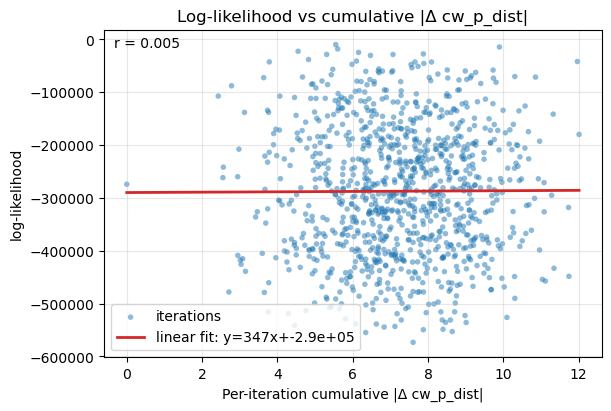

In [436]:
# Log-likelihood vs per-iteration cumulative |Δ cw_p_dist| (scatter + trend)

# Load from memory if available; otherwise from disk
try:
    res_ll = results_loglik
except NameError:
    with open('loglik_perturb_results.pkl', 'rb') as f:
        res_ll = pickle.load(f)

ll_vals = np.asarray(res_ll.get('log_likelihoods', []), dtype=float)
cumdiffs = np.asarray(res_ll.get('cumulative_diffs', []), dtype=float)

# Fallback for cumulative diffs if not present
if cumdiffs.size == 0:
    try:
        res_h = results
    except NameError:
        with open('hessian_perturb_results.pkl', 'rb') as f:
            res_h = pickle.load(f)
    cumdiffs = np.asarray(res_h.get('cumulative_diffs', []), dtype=float)

# Align lengths
n = min(ll_vals.size, cumdiffs.size)
ll_vals = ll_vals[:n]
cumdiffs = cumdiffs[:n]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
if n:
    ax.scatter(cumdiffs, ll_vals, s=16, alpha=0.5, color='C0', edgecolor='none', label='iterations')

    # Linear trend
    try:
        m, b = np.polyfit(cumdiffs, ll_vals, 1)
        xf = np.linspace(cumdiffs.min(), cumdiffs.max(), 100)
        ax.plot(xf, m * xf + b, color='C3', lw=2, label=f'linear fit: y={m:.3g}x+{b:.3g}')
    except Exception:
        pass

    # Correlation
    try:
        r = float(np.corrcoef(cumdiffs, ll_vals)[0, 1])
        ax.text(0.02, 0.98, f'r = {r:.3f}', transform=ax.transAxes, va='top')
    except Exception:
        pass

    ax.set_xlabel('Per-iteration cumulative |Δ cw_p_dist|')
    ax.set_ylabel('log-likelihood')
    ax.set_title('Log-likelihood vs cumulative |Δ cw_p_dist|')
    ax.grid(True, alpha=0.3)
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center')
    ax.axis('off')

plt.show()


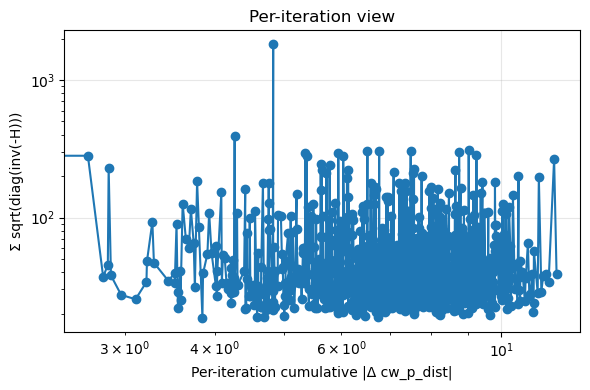

In [437]:
# Plot: sum sqrt(diag(inv(-H))) vs cw_p_dist perturbations (per-iteration only)
import pickle
import numpy as np
import matplotlib.pyplot as plt


def sum_sqrt_diag_inv_neg_hessian(H: np.ndarray) -> float:
    """Compute sum(sqrt(abs(diag(inv(-H))))) safely.
    Falls back to pseudo-inverse if -H is singular or ill-conditioned."""
    M = -np.array(H, dtype=float)
    try:
        cov = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(M)
    d = np.diag(cov)
    # Numerical safety: abs before sqrt
    return float(np.sum(np.sqrt(np.abs(d))))

# Load results from memory if available, otherwise from disk
outpath = 'hessian_perturb_results.pkl'
res = globals().get('results')
if res is None:
    with open(outpath, 'rb') as f:
        res = pickle.load(f)

hessians = [np.asarray(h, dtype=float) for h in res.get('hessians', [])]
if len(hessians) == 0:
    raise RuntimeError("No Hessians found in results; run the perturbation cell first.")

# Per-iteration cumulative |Δ| for cw_p_dist
cumdiffs = np.asarray(res.get('cumulative_diffs', []), dtype=float)

# Compute the requested metric for each Hessian
metric = np.array([sum_sqrt_diag_inv_neg_hessian(H) for H in hessians], dtype=float)

# Single-panel plot: per-iteration view (sorted by per-iteration cumulative |Δ|)
plt.figure(figsize=(6, 4))
if cumdiffs.size == metric.size and cumdiffs.size > 0:
    idx = np.argsort(cumdiffs)
    plt.plot(cumdiffs[idx], metric[idx], 'o-', color='tab:blue')
    plt.xlabel('Per-iteration cumulative |Δ cw_p_dist|')
    plt.ylabel('Σ sqrt(diag(inv(-H)))')
    plt.title('Per-iteration view')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Per-iteration data unavailable', ha='center', va='center')
    plt.gca().axis('off')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()


In [438]:
hessians

[array([[-1.34848623e+10,  5.29103839e+05,  1.30008111e+06, ...,
         -2.49828841e+07, -1.23609450e+10,  3.81588101e+09],
        [ 5.29103839e+05,  1.36254766e+01,  4.70039946e+01, ...,
          2.80604740e+02,  4.84770199e+05, -1.49839939e+05],
        [ 1.30008111e+06,  4.70039946e+01,  1.53741523e+02, ...,
          6.93058498e+02,  1.19114793e+06, -3.68176642e+05],
        ...,
        [-2.49828841e+07,  2.80604740e+02,  6.93058498e+02, ...,
          1.12287728e+06,  4.43496618e+09, -1.75436537e+09],
        [-1.23609450e+10,  4.84770199e+05,  1.19114793e+06, ...,
          4.43496618e+09,  1.12649102e+13, -5.45560524e+12],
        [ 3.81588101e+09, -1.49839939e+05, -3.68176642e+05, ...,
         -1.75436537e+09, -5.45560524e+12,  2.28509851e+12]],
       shape=(39, 39)),
 array([[-1.85646697e+10, -1.12945599e+05, -1.99226875e+05, ...,
         -7.08316679e+06, -2.33863045e+10,  7.23033049e+09],
        [-1.12945599e+05, -1.54040334e+01, -3.13246560e+01, ...,
         -2.523

In [439]:
for h in hessians:
    print(jnp.sum(jnp.sqrt(jnp.diagonal(jnp.linalg.inv(-h)))))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [440]:
jnp.diagonal(jnp.linalg.inv(-h))

Array([ 3.05641958e-09,  2.21307358e-01,  1.57906448e-02,  2.77010187e-09,
        2.00207910e-04, -5.12290562e-05,  1.31329461e-07,  4.28460266e-02,
       -6.76250575e-05,  1.42346501e-08, -1.14713253e-02, -7.19404439e-04,
        3.62678099e-11, -1.00184559e-02, -7.58565943e-04, -1.53037270e-08,
       -6.87787829e-01, -5.08056860e-02,  1.38863665e-07, -5.25501856e-01,
       -1.50972981e-01,  2.52313394e-09, -2.36721858e+02, -1.78940547e+01,
       -7.84460097e-11,  5.36280678e-02,  2.69200819e-03, -3.34009483e-08,
       -9.92158711e+00, -1.83676897e+00, -2.99521771e-01, -5.55608790e-02,
        3.27486602e-07,  1.22978108e-10, -6.09829475e-08, -1.23927337e-05,
        1.01951322e-07, -4.67184170e-10, -1.10972120e-09], dtype=float64)

In [442]:
fml.logL.params

['B1855+09_cw_p_dist',
 'B1855+09_rednoise_gamma',
 'B1855+09_rednoise_log10_A',
 'B1937+21_cw_p_dist',
 'B1937+21_rednoise_gamma',
 'B1937+21_rednoise_log10_A',
 'B1953+29_cw_p_dist',
 'B1953+29_rednoise_gamma',
 'B1953+29_rednoise_log10_A',
 'J0023+0923_cw_p_dist',
 'J0023+0923_rednoise_gamma',
 'J0023+0923_rednoise_log10_A',
 'J0030+0451_cw_p_dist',
 'J0030+0451_rednoise_gamma',
 'J0030+0451_rednoise_log10_A',
 'J0125-2327_cw_p_dist',
 'J0125-2327_rednoise_gamma',
 'J0125-2327_rednoise_log10_A',
 'J0340+4130_cw_p_dist',
 'J0340+4130_rednoise_gamma',
 'J0340+4130_rednoise_log10_A',
 'J0406+3039_cw_p_dist',
 'J0406+3039_rednoise_gamma',
 'J0406+3039_rednoise_log10_A',
 'J0437-4715_cw_p_dist',
 'J0437-4715_rednoise_gamma',
 'J0437-4715_rednoise_log10_A',
 'J0509+0856_cw_p_dist',
 'J0509+0856_rednoise_gamma',
 'J0509+0856_rednoise_log10_A',
 'crn_gamma',
 'crn_log10_A',
 'cw_cosinc',
 'cw_log10_f0',
 'cw_log10_h0',
 'cw_phi_earth',
 'cw_psi',
 'cw_ra',
 'cw_sindec']